# Análisis comparativo del agente por versión

Este notebook realiza un análisis completo del comportamiento aprendido por el agente en las diferentes versiones.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import yaml
from collections import Counter

---

## Aspectos generales

---

In [2]:
# Rutas base por versión
base_paths = {
    "v1": "v1_simple_movement/results",
    "v2": "v2_pass_shot_probability/results",
    "v3": "v3_defense_interception/results",
    "v4": "v4_player_roles_influence/results"
}

mlruns_root = "mlruns"
run_records = []
df_list = []

# Mapear experiment_id a versión usando meta.yaml
expid_to_version = {}
for exp_id in os.listdir(mlruns_root):
    meta_path = os.path.join(mlruns_root, exp_id, "meta.yaml")
    if os.path.isfile(meta_path):
        with open(meta_path, "r", encoding="utf-8") as f:
            meta = yaml.safe_load(f)
            name = meta.get("name", "")
            for v in base_paths:
                if name == f"Basketball RL Model {v.upper()}":
                    expid_to_version[exp_id] = v


for version, base_path in base_paths.items():
    for root, dirs, files in os.walk(base_path):
        folder_name = os.path.basename(root)
        if folder_name.startswith(f"model_{version}_20250616"):
            episode_data_path = None
            run_id_path = None

            for file in files:
                if file == "episode_data.csv":
                    episode_data_path = os.path.normpath(os.path.join(root, file)).replace("\\", "/")
                elif file == "mlflow_run_id.txt":
                    run_id_path = os.path.normpath(os.path.join(root, file)).replace("\\", "/")

            if episode_data_path and run_id_path:
                try:
                    with open(run_id_path, "r") as f:
                        run_id = f.read().strip()

                    # Buscar la carpeta de experimento correspondiente (ruta relativa al proyecto)
                    mlflow_run_path = None
                    total_iters = None
                    for exp_id, v in expid_to_version.items():
                        if v == version:
                            candidate = os.path.join(mlruns_root, exp_id, run_id)
                            if os.path.isdir(candidate):
                                mlflow_run_path = candidate.replace("\\", "/")
                                # Leer el valor de total_iters
                                params_path = os.path.join(candidate, "params", "total_iters")
                                if os.path.isfile(params_path):
                                    with open(params_path, "r") as pf:
                                        total_iters = pf.read().strip()
                                break

                    run_records.append({
                        "version": version,
                        "carpeta": folder_name,
                        "ruta_csv": episode_data_path,
                        "mlflow_run_id": run_id,
                        "mlflow_run_path": mlflow_run_path,
                        "total_iters": total_iters
                    })

                    # Cargar episodio y añadir a df_total
                    df = pd.read_csv(episode_data_path)
                    df["version"] = version
                    df["run_id"] = run_id
                    df["total_iters"] = total_iters
                    df_list.append(df)

                except Exception as e:
                    print(f"Error en {folder_name}: {e}")

# Crear DataFrame con metainformación
df_runs = pd.DataFrame(run_records).sort_values(by=["version"]).reset_index(drop=True)

# Crear DataFrame combinado de datos
df_total = pd.concat(df_list, ignore_index=True)
cols = ['version', 'run_id', 'total_iters'] + [col for col in df_total.columns if col not in ['version', 'run_id', 'total_iters']]
df_total = df_total[cols]


In [3]:
display(df_runs)

,version,carpeta,ruta_csv,mlflow_run_id,mlflow_run_path,total_iters
0,v1,model_v1_20250616_124517,v1_simple_movement/results/model_v1_20250616_1...,480ca07d0c4747a9addbe7eb62ffeb27,mlruns/567943723938219734/480ca07d0c4747a9addb...,500
1,v1,model_v1_20250616_124630,v1_simple_movement/results/model_v1_20250616_1...,91268c259e254199a8e16a6a07be9895,mlruns/567943723938219734/91268c259e254199a8e1...,1000
2,v1,model_v1_20250616_124650,v1_simple_movement/results/model_v1_20250616_1...,4406febaaf7b4fcfbe3e8a87c7817fac,mlruns/567943723938219734/4406febaaf7b4fcfbe3e...,10000
3,v1,model_v1_20250616_124715,v1_simple_movement/results/model_v1_20250616_1...,8dbcf0c4b8ed4174bbeffd3b43e0b11e,mlruns/567943723938219734/8dbcf0c4b8ed4174bbef...,50000
4,v1,model_v1_20250616_124802,v1_simple_movement/results/model_v1_20250616_1...,5afe2fe67c7a4f719f6055f58c32b121,mlruns/567943723938219734/5afe2fe67c7a4f719f60...,100000
5,v2,model_v2_20250616_125240,v2_pass_shot_probability/results/model_v2_2025...,50aaf7fda83d466c8febbff9881b45d8,mlruns/551999912424070669/50aaf7fda83d466c8feb...,50000
6,v2,model_v2_20250616_125159,v2_pass_shot_probability/results/model_v2_2025...,2e82bb95e11e49f3a6a96500c7a3e219,mlruns/551999912424070669/2e82bb95e11e49f3a6a9...,10000
7,v2,model_v2_20250616_125451,v2_pass_shot_probability/results/model_v2_2025...,29bf3dc5da4a40c59e3eba50a1195ef5,mlruns/551999912424070669/29bf3dc5da4a40c59e3e...,100000
8,v2,model_v2_20250616_125048,v2_pass_shot_probability/results/model_v2_2025...,8453dc7bb3e544708d449440941b2eff,mlruns/551999912424070669/8453dc7bb3e544708d44...,500
9,v2,model_v2_20250616_125120,v2_pass_shot_probability/results/model_v2_2025...,33260e0b530c47e19dac3b57834949a7,mlruns/551999912424070669/33260e0b530c47e19dac...,1000


In [4]:
display(df_total)

,version,run_id,total_iters,episode,step,action,reward,player_row,player_col,ball_row,...,p6_row,p6_col,p7_row,p7_col,p8_row,p8_col,p9_row,p9_col,prob_info,player_name
0,v1,480ca07d0c4747a9addbe7eb62ffeb27,500,0,1,2,0.0,5,12,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,v1,480ca07d0c4747a9addbe7eb62ffeb27,500,0,2,1,0.0,6,12,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,v1,480ca07d0c4747a9addbe7eb62ffeb27,500,0,3,3,0.0,6,12,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,v1,480ca07d0c4747a9addbe7eb62ffeb27,500,0,4,4,3.0,6,12,6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,v1,480ca07d0c4747a9addbe7eb62ffeb27,500,1,5,1,0.0,5,13,5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
659032,v4,b3d62b11a0384c8dabf11cd58dd6b666,100000,9664,100331,"[1, 0, 1, 3, 2]",0.0,6,12,6,...,5.0,13.0,7.0,13.0,8.0,13.0,9.0,12.0,"{'base': 0.26, 'final': 0.26, 'penalty': 0, 'd...",james_harden
659033,v4,b3d62b11a0384c8dabf11cd58dd6b666,100000,9664,100332,"[0, 0, 3, 1, 1]",0.0,5,12,5,...,4.0,13.0,7.0,13.0,9.0,13.0,10.0,12.0,"{'base': 0.26, 'final': 0.26, 'penalty': 0, 'd...",james_harden
659034,v4,b3d62b11a0384c8dabf11cd58dd6b666,100000,9664,100333,"[5, 0, 1, 1, 2]",0.0,10,11,10,...,3.0,13.0,8.0,13.0,10.0,13.0,10.0,11.0,"{'base': 0.48, 'final': 0.48, 'penalty': 0, 'd...",ivica_zubac
659035,v4,b3d62b11a0384c8dabf11cd58dd6b666,100000,9664,100334,"[1, 0, 2, 1, 2]",0.0,10,10,10,...,2.0,13.0,8.0,12.0,11.0,13.0,10.0,10.0,"{'base': 0.48, 'final': 0.48, 'penalty': 0, 'd...",ivica_zubac


Separación de versiones

In [4]:
df_v1 = df_total[df_total["version"] == "v1"].copy()
df_v2 = df_total[df_total["version"] == "v2"].copy()
df_v3 = df_total[df_total["version"] == "v3"].copy()
df_v4 = df_total[df_total["version"] == "v4"].copy()

Frecuencia de acciones por versión

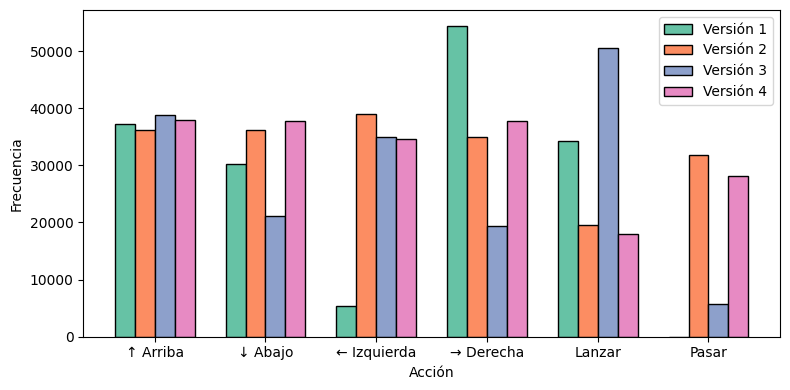

In [7]:
# --- Versión 1: acción simple ---
action_map_v1 = {
    0: "↑ Arriba",
    1: "↓ Abajo",
    2: "← Izquierda",
    3: "→ Derecha",
    4: "Lanzar"
}
orden_v1 = [action_map_v1[i] for i in sorted(action_map_v1.keys())]
df_v1["action_name"] = df_v1["action"].map(action_map_v1)
conteo_v1 = df_v1["action_name"].value_counts().reindex(orden_v1).fillna(0)
valores_v1 = conteo_v1.values.tolist()

# --- Otras versiones ---
def contar_acciones(df, tiene_pasar=True):
    acciones_0_4, acciones_5 = [], []
    for _, row in df.iterrows():
        acciones_row = row["action"]
        if isinstance(acciones_row, str):
            acciones_row = eval(acciones_row)
        jugadores_equipo = list(range(5, 10))
        try:
            jugador_con_balon = int(row["player_idx"])
            if jugador_con_balon in jugadores_equipo:
                idx_con_balon = jugadores_equipo.index(jugador_con_balon)
                accion_balon = acciones_row[idx_con_balon]
                if accion_balon in range(0, 5):
                    acciones_0_4.append(action_map[accion_balon])
        except Exception:
            continue
        if tiene_pasar:
            for idx, accion in enumerate(acciones_row):
                if idx in range(0, 5):
                    if accion == 5:
                        acciones_5.append(action_map[5])
    acciones = acciones_0_4 + acciones_5
    conteo = Counter(acciones)
    return [conteo.get(nombre, 0) for nombre in orden]

action_map = { #mirando a la canasta
    0: "↑ Arriba",
    1: "↓ Abajo",
    2: "← Izquierda",
    3: "→ Derecha", 
    4: "Lanzar",
    5: "Pasar",
}
orden = [action_map[i] for i in sorted(action_map.keys())]

valores_v2 = contar_acciones(df_v2)
valores_v3 = contar_acciones(df_v3)
valores_v4 = contar_acciones(df_v4)

# Para la gráfica, iguala la longitud de valores_v1 a 6 (rellena con 0 para "Pasar")
valores_v1_full = valores_v1 + [0]  # Añade 0 para "Pasar"

valores = np.array([valores_v1_full, valores_v2, valores_v3, valores_v4])

x = np.arange(len(orden))
width = 0.18

# Paleta progresiva pastel para 4 versiones
colores = sns.color_palette("Set2", 4)

plt.figure(figsize=(8, 4))
plt.bar(x - 1.5*width, valores[0], width, label="Versión 1", edgecolor="black", color=colores[0])
plt.bar(x - 0.5*width, valores[1], width, label="Versión 2", edgecolor="black", color=colores[1])
plt.bar(x + 0.5*width, valores[2], width, label="Versión 3", edgecolor="black", color=colores[2])
plt.bar(x + 1.5*width, valores[3], width, label="Versión 4", edgecolor="black", color=colores[3])

plt.xlabel("Acción")
plt.ylabel("Frecuencia")
plt.xticks(x, orden, rotation=0)
plt.legend()
plt.tight_layout()
plt.show()

Distribución de lanzamientos según momento del episodio

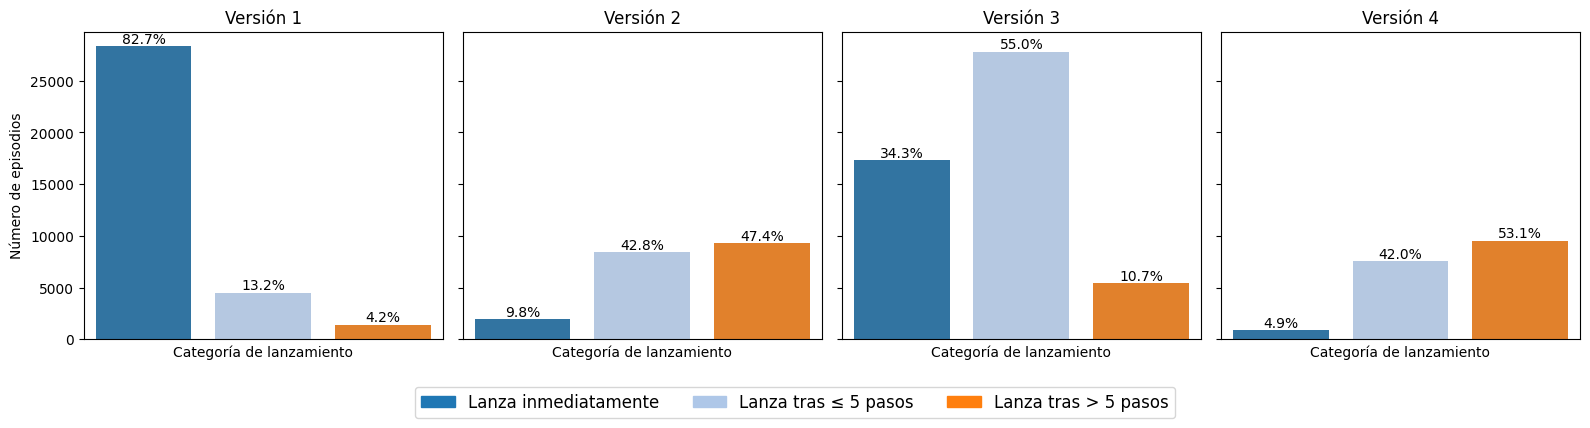

In [8]:
categorias_orden = [
    "Lanza inmediatamente",
    "Lanza tras ≤ 5 pasos",
    "Lanza tras > 5 pasos"
]

def clasificar_lanzamientos_steps(df, action_col="action"):
    categorias_orden = [
        "Lanza inmediatamente",
        "Lanza tras ≤ 5 pasos",
        "Lanza tras > 5 pasos"
    ]
    categorias = []
    for _, episode_df in df.groupby(["run_id", "episode"]):
        acciones = episode_df[action_col].tolist()
        found = False
        for idx, acc in enumerate(acciones):
            # Si es string, evalúa a lista
            if isinstance(acc, str):
                try:
                    acc = eval(acc)
                except Exception:
                    continue
            # Si es lista, busca si algún jugador lanza
            if isinstance(acc, list):
                if 4 in acc:
                    found = True
            else:
                if acc == 4:
                    found = True
            if found:
                if idx == 0:
                    categorias.append(categorias_orden[0])
                elif idx <= 5:
                    categorias.append(categorias_orden[1])
                else:
                    categorias.append(categorias_orden[2])
                break
    return pd.Series(categorias).value_counts().reindex(categorias_orden).fillna(0)

# Graficar los 4 en una línea y leyenda debajo
versiones = ["Versión 1", "Versión 2", "Versión 3", "Versión 4"]
colores = sns.color_palette("tab20", 3)
conteos = []
porcentajes = []

for df in [df_v1, df_v2, df_v3, df_v4]:
    conteo = clasificar_lanzamientos_steps(df)
    pct = 100 * conteo / conteo.sum()
    conteos.append(conteo)
    porcentajes.append(pct)

fig, axs = plt.subplots(1, 4, figsize=(16, 4), sharey=True)
for i, ax in enumerate(axs):
    sns.barplot(
        x=list(range(len(conteos[i]))),
        y=conteos[i].values,
        hue=categorias_orden,
        palette=colores,
        legend=False,
        ax=ax
    )
    ax.set_xticks([])
    ax.set_title(versiones[i])
    ax.set_xlabel("Categoría de lanzamiento")
    if i == 0:
        ax.set_ylabel("Número de episodios")
    else:
        ax.set_ylabel("")
    # Porcentajes encima de cada barra
    for j, (valor, pct) in enumerate(zip(conteos[i].values, porcentajes[i].values)):
        ax.text(j, valor + 0.5, f"{pct:.1f}%", ha="center", va="bottom", fontsize=10)

# Leyenda personalizada en la parte inferior en una línea
handles = [plt.Rectangle((0,0),1,1, color=colores[i]) for i in range(len(categorias_orden))]
fig.legend(handles, categorias_orden, loc="lower center", bbox_to_anchor=(0.5, -0.08), ncol=len(categorias_orden), fontsize=12)

plt.tight_layout(rect=[0, 0.05, 1, 1])
plt.show()


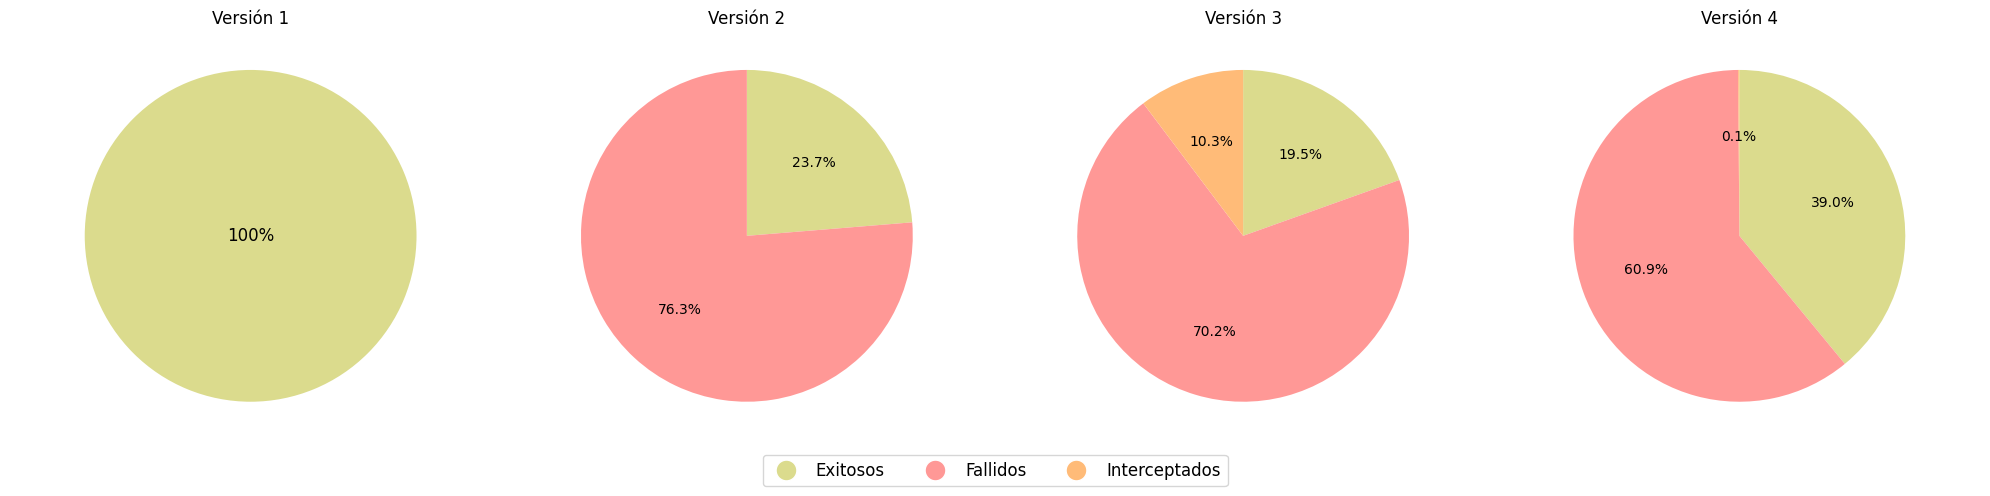

In [66]:
# Pie charts consecutivos para versiones 1, 2, 3 y 4 (v1 siempre 100% exitosos)
version_dfs = [df_v1, df_v2, df_v3, df_v4]
version_names = ["Versión 1", "Versión 2", "Versión 3", "Versión 4"]
all_labels = ['Exitosos', 'Fallidos', 'Interceptados']
all_colores = ["#A2ECBF", "#FF838393", "#FFE79E"]  # verde, rojo y amarillo pastel ligeramente más claros
# Usa los colores de tab20 para mantener la coherencia visual, pero elige los tonos más parecidos a verde, rojo y amarillo
tab20 = sns.color_palette("tab20", 20)
# Verde, rojo y amarillo pastel de tab20
colores_tab20 = [tab20[17], tab20[7], tab20[3]]  # Puedes ajustar los índices si prefieres otros tonos

all_colores = colores_tab20 

fig, axs = plt.subplots(1, 4, figsize=(20, 5))

for i, (df, name) in enumerate(zip(version_dfs, version_names)):
    if i == 0:
        # Versión 1: 100% exitosos, sin leer datos
        sizes_plot = [1]
        labels_plot = [all_labels[0]]
        colores_plot = [all_colores[0]]
        wedges, texts, autotexts = axs[i].pie(
            sizes_plot,
            autopct='',
            colors=colores_plot,
            startangle=90,
            counterclock=False
        )
        # Añadir el 100% en el centro
        axs[i].text(0, 0, "100%", ha='center', va='center', fontsize=12)
    else:
        df['is_shot'] = df['shot'].isin(['shot_failed', 'shot_successful', 'intercepted_shot'])
        df['is_shot_success'] = df['shot'] == 'shot_successful'
        df['is_shot_fail'] = df['shot'] == 'shot_failed'
        df['is_shot_intercepted'] = df['shot'] == 'intercepted_shot'
        successful_shots = df['is_shot_success'].sum()
        failed_shots = df['is_shot_fail'].sum()
        intercepted_shots = df['is_shot_intercepted'].sum()
        total_shots = successful_shots + failed_shots + intercepted_shots

        # Si no hay tiros fallidos ni interceptados y hay al menos un tiro, es 100% exitosos
        if failed_shots == 0 and intercepted_shots == 0 and successful_shots > 0:
            sizes_plot = [successful_shots]
            labels_plot = [all_labels[0]]
            colores_plot = [all_colores[0]]
        elif intercepted_shots == 0:
            sizes_plot = [successful_shots, failed_shots]
            labels_plot = all_labels[:2]
            colores_plot = all_colores[:2]
        else:
            sizes_plot = [successful_shots, failed_shots, intercepted_shots]
            labels_plot = all_labels
            colores_plot = all_colores

        axs[i].pie(
            sizes_plot,
            autopct='%1.1f%%',
            colors=colores_plot,
            startangle=90,
            counterclock=False
        )
    axs[i].set_title(f'{name}', pad=1)
    axs[i].axis('equal')

# Leyenda única debajo de los gráficos
handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                      markerfacecolor=color, markersize=15)
           for label, color in zip(all_labels, all_colores)]
fig.legend(handles, all_labels, loc='lower center', bbox_to_anchor=(0.5, 0), ncol=3, fontsize=12)

plt.tight_layout(rect=[0, 0.07, 1, 1])
plt.show()

---

## Version 1: Entorno básico y controlado

---

Distribución de recompensas por episodio y ejecución

In [6]:
# Calcular la recompensa total por episodio y ejecución solo cuando done == True
reward_by_episode = (
    df_v1[df_v1["done"] == True]
    .groupby(["run_id", "episode"])["reward"]
    .sum()
    .reset_index()
)
# Contar cuántos episodios tienen cada valor de recompensa total (en todas las ejecuciones)
reward_counts = reward_by_episode["reward"].value_counts().sort_index()

print(reward_counts)

reward
2.0        2
3.0    34259
Name: count, dtype: int64


Funciones para mapas de calor de posiciones de lanzamientos, de pases y del jugador con balón

In [66]:
def heatmap_pos_balon(df, log=True):
    df_pos_balon = df[(df["ball_row"] == df["player_row"]) & (df["ball_col"] == df["player_col"])]
    pivot = df_pos_balon.pivot_table(index='player_row', columns='player_col', aggfunc='size', fill_value=0)
    plt.figure(figsize=(9, 6))
    data = np.log1p(pivot) if log else pivot
    fmt = ".1f" if log else "d"
    sns.heatmap(data, cmap="Reds", annot=True, fmt=fmt, linewidths=0.5, cbar=True, vmin=0, vmax=11 if log else None)
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.tight_layout()
    rect = plt.Rectangle((0, 7), 1, 1, fill=True, edgecolor='grey', linewidth=2, facecolor='white')
    plt.gca().add_patch(rect)
    rect_custom = plt.Rectangle((13, 5), 1, 1, fill=False, edgecolor='yellow', linewidth=3)
    plt.gca().add_patch(rect_custom)
    plt.show()

def heatmap_accion(df, accion, log=True):
    # accion: 4 para lanzar, 5 para pasar
    mask = df["action"].apply(
        lambda x: accion in eval(x) if isinstance(x, str) else (accion in x if isinstance(x, list) else x == accion)
    )
    positions = df[mask]
    heatmap_data = positions.groupby(["player_row", "player_col"]).size().unstack(fill_value=0)
    all_cols = np.arange(0, 14)
    heatmap_data = heatmap_data.reindex(columns=all_cols, fill_value=0)
    plt.figure(figsize=(9, 6))
    data = np.log1p(heatmap_data) if log else heatmap_data
    fmt = ".1f" if log else "d"
    sns.heatmap(data, cmap="Reds", annot=True, fmt=fmt, cbar=True, vmin=0, vmax=11 if log else None)
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.tight_layout()
    rect = plt.Rectangle((0, 7), 1, 1, fill=True, edgecolor='grey', linewidth=2, facecolor='white')
    plt.gca().add_patch(rect)
    rect_custom = plt.Rectangle((13, 5), 1, 1, fill=False, edgecolor='yellow', linewidth=3)
    plt.gca().add_patch(rect_custom)
    plt.show()

def heatmap_intercepciones(df, log=True):
    positions = df[df["shot"].isin(["intercepted_shot", "intercepted_pass"])]
    heatmap_data = positions.groupby(["player_row", "player_col"]).size().unstack(fill_value=0)
    all_cols = np.arange(0, 14)
    heatmap_data = heatmap_data.reindex(columns=all_cols, fill_value=0)
    plt.figure(figsize=(9, 6))
    data = np.log1p(heatmap_data) if log else heatmap_data
    fmt = ".1f" if log else "d"
    sns.heatmap(data, cmap="Reds", annot=True, fmt=fmt, cbar=True, vmin=0, vmax=11 if log else None)
    plt.xlabel("Columna")
    plt.ylabel("Fila")
    plt.tight_layout()
    rect = plt.Rectangle((0, 7), 1, 1, fill=True, edgecolor='grey', linewidth=2, facecolor='white')
    plt.gca().add_patch(rect)
    rect_custom = plt.Rectangle((13, 5), 1, 1, fill=False, edgecolor='yellow', linewidth=3)
    plt.gca().add_patch(rect_custom)
    plt.show()

Mapa de calor de posiciones de lanzamiento

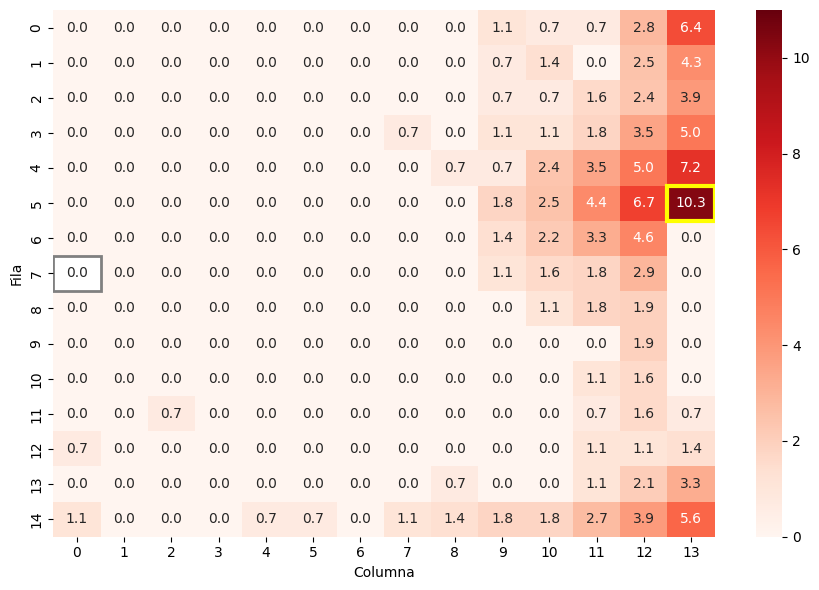

In [62]:
heatmap_accion(df_v1, 4)

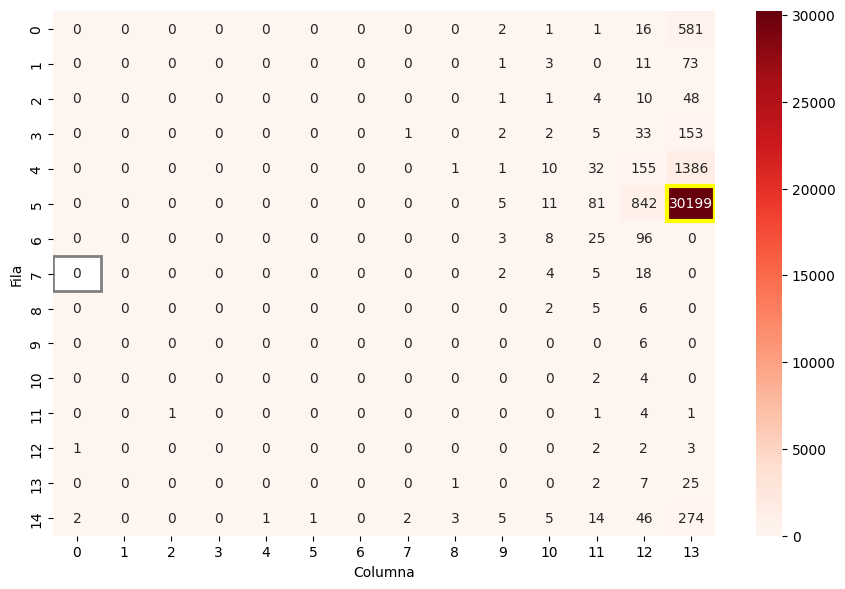

In [63]:
heatmap_accion(df_v1, 4, log=False) 

Mapa de calor de posiciones del jugador

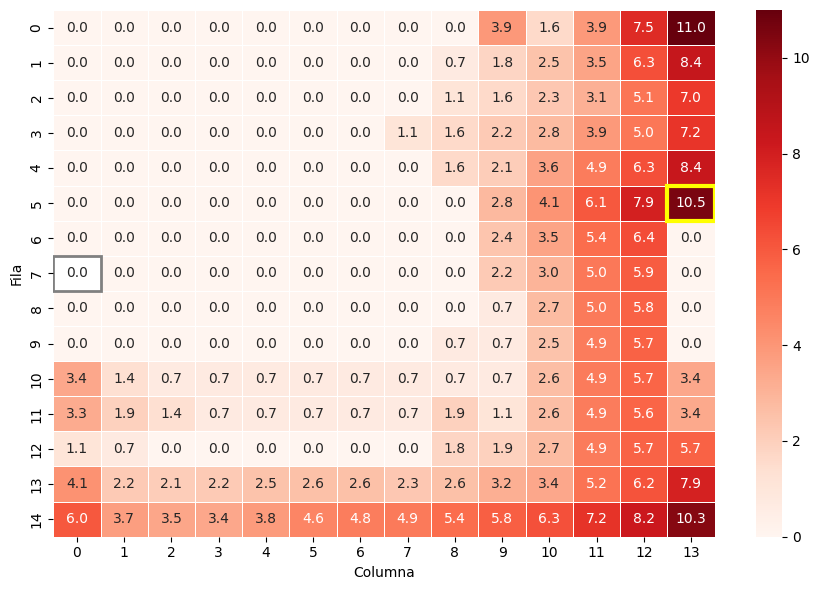

In [64]:
heatmap_pos_balon(df_v1, log=True)

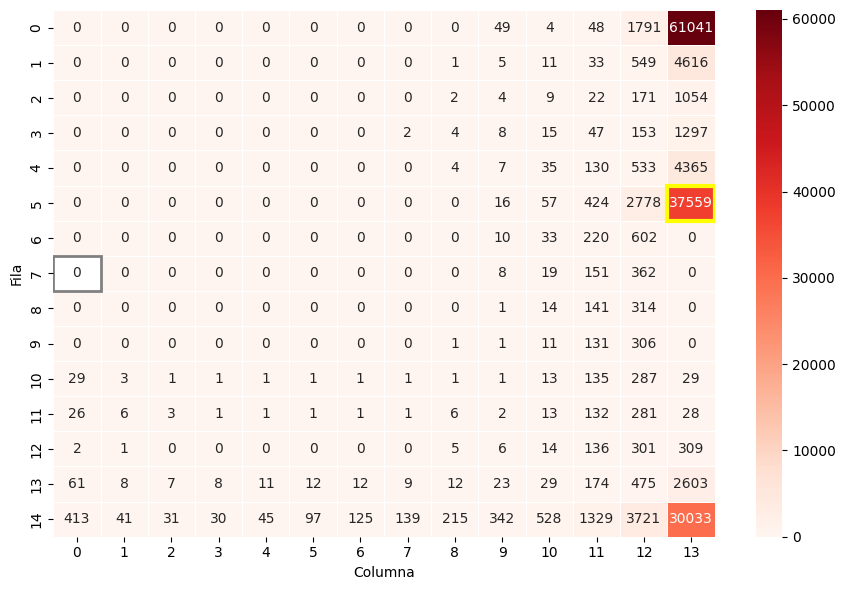

In [65]:
heatmap_pos_balon(df_v1, log=False)

In [13]:
# Calcular la duración media de los episodios (por run_id y episodio)
episodio_lens = df_v1.groupby(["run_id", "episode"])["step"].count()
print(f"Duración mediana de los episodios: {episodio_lens.median():.2f} pasos") 
print(f"Duración media de los episodios: {episodio_lens.mean():.2f} pasos")

Duración mediana de los episodios: 1.00 pasos
Duración media de los episodios: 4.71 pasos


In [14]:
# Asegúrate de que total_iters es numérico
df_v1["total_iters"] = pd.to_numeric(df_v1["total_iters"], errors="coerce")

# Calcular métricas por total_iters
resumen = []
for iters, group in df_v1.groupby("total_iters"):
    # Recompensa media por episodio
    reward_by_ep = group[group["done"] == True].groupby(["run_id", "episode"])["reward"].sum()
    recompensa_media = reward_by_ep.mean()
    recompensa_max = reward_by_ep.max()
    # % tiros inmediatos
    episodios = group.groupby(["run_id", "episode"])
    tiros_inmediatos = 0
    total_episodios = 0
    for _, ep in episodios:
        acciones = ep["action"].tolist()
        if 4 in acciones:
            total_episodios += 1
            if acciones.index(4) == 0:
                tiros_inmediatos += 1
    pct_tiros_inmediatos = 100 * tiros_inmediatos / total_episodios if total_episodios > 0 else 0
    resumen.append({
        "Iteraciones": int(iters),
        "Recompensa media": f"{recompensa_media:.2f}",
        "% tiros inmediatos": f"{pct_tiros_inmediatos:.1f}%",
        "Recompensa máx.": f"{recompensa_max:.2f}"
    })

tabla_resumen = pd.DataFrame(resumen).sort_values("Iteraciones")
display(tabla_resumen)

# Si quieres exportar a LaTeX:
#print(tabla_resumen.to_latex(index=False, caption="Resumen de métricas por número de iteraciones en la versión 1.", label="tab:resumen_v1"))

,Iteraciones,Recompensa media,% tiros inmediatos,Recompensa máx.
0,500,3.00,92.9%,3.00
1,1000,3.00,94.8%,3.00
2,10000,3.00,94.3%,3.00
3,50000,3.00,78.2%,3.00
4,100000,3.00,77.0%,3.00


---

## Version 2: Interacción y lógica de tiro

---

Mapa de calor de posiciones de lanzamiento

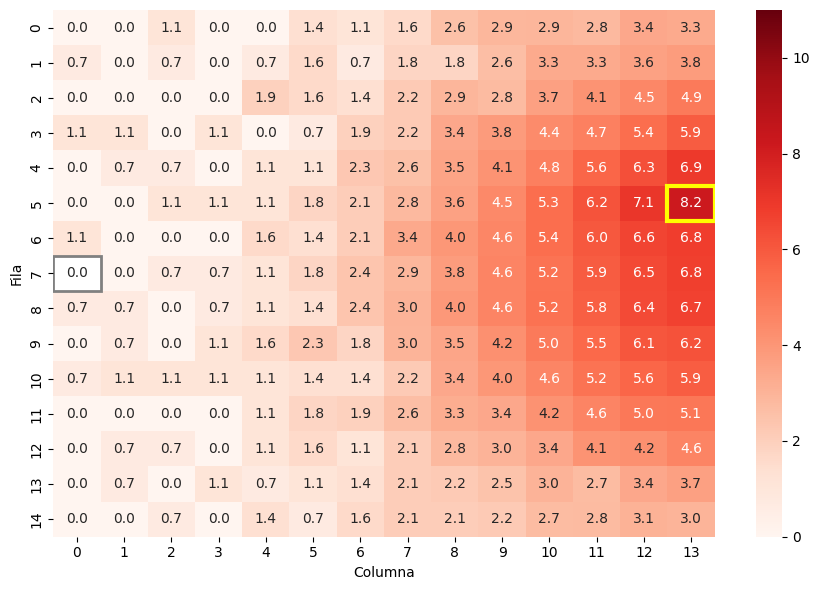

In [51]:
heatmap_accion(df_v2, 4)

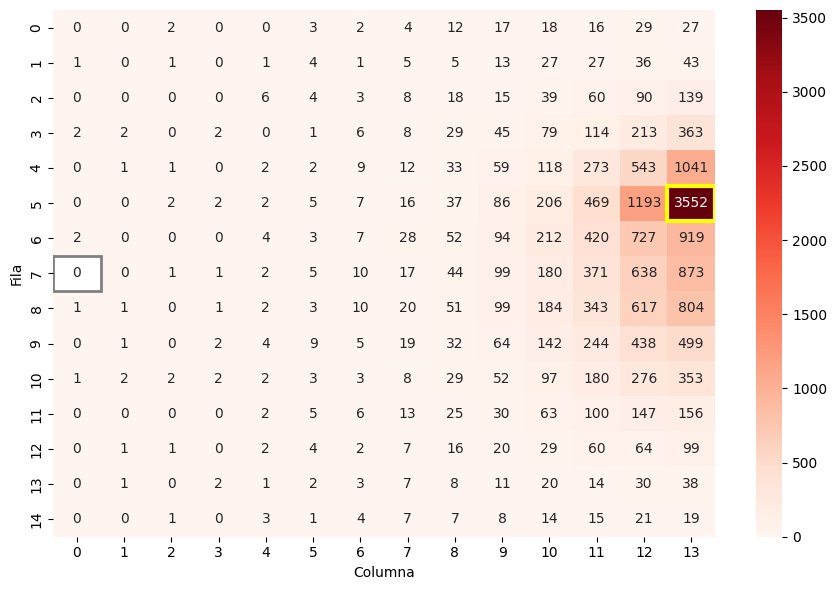

In [69]:
heatmap_accion(df_v2, 4, log=False)

Mapa de calor de posiciones de jugador con posesión del balón

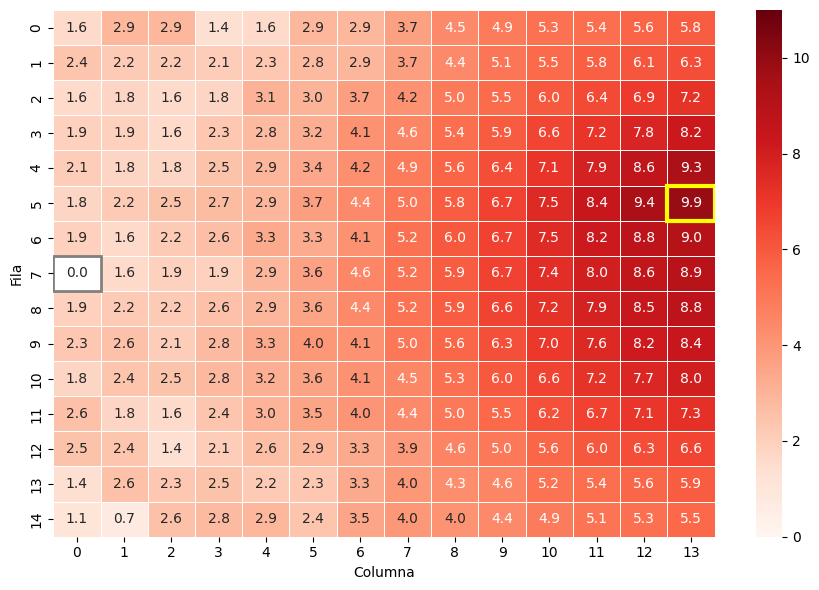

In [85]:
heatmap_pos_balon(df_v2, log=True)

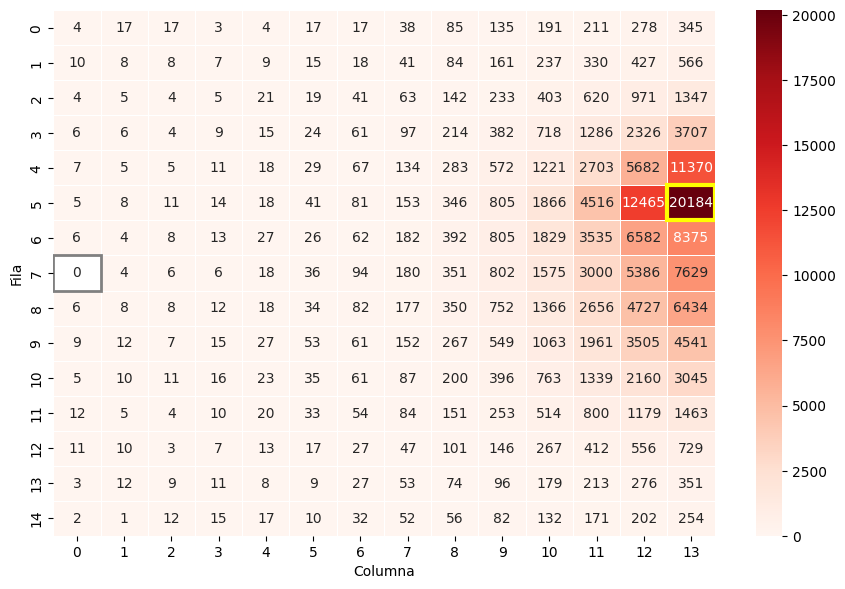

In [72]:
heatmap_pos_balon(df_v2, log=False)

In [20]:
# Calcular la duración media de los episodios (por run_id y episodio)
episodio_lens = df_v2.groupby(["run_id", "episode"])["step"].count()
print(f"Duración mediana de los episodios: {episodio_lens.median():.2f} pasos") 
print(f"Duración media de los episodios: {episodio_lens.mean():.2f} pasos")

Duración mediana de los episodios: 6.00 pasos
Duración media de los episodios: 8.46 pasos


In [21]:
# Calcular métricas por total_iters para versión 2, considerando que las acciones son listas
df_v2["total_iters"] = pd.to_numeric(df_v2["total_iters"], errors="coerce")

resumen_v2 = []
for iters, group in df_v2.groupby("total_iters"):
    # Recompensa media por episodio
    reward_by_ep = group[group["done"] == True].groupby(["run_id", "episode"])["reward"].sum()
    recompensa_media = reward_by_ep.mean()
    recompensa_max = reward_by_ep.max()
    # % tiros inmediatos (primer paso del episodio contiene un 4 en la lista de acciones)
    episodios = group.groupby(["run_id", "episode"])
    tiros_inmediatos = 0
    total_episodios = 0
    for _, ep in episodios:
        acciones = ep["action"].tolist()
        if len(acciones) > 0:
            acc_0 = acciones[0]
            # Si es string, evalúa a lista
            if isinstance(acc_0, str):
                try:
                    acc_0 = eval(acc_0)
                except Exception:
                    continue
            # Si es lista y contiene un 4, es tiro inmediato
            if isinstance(acc_0, list) and 4 in acc_0:
                tiros_inmediatos += 1
            total_episodios += 1
    pct_tiros_inmediatos = 100 * tiros_inmediatos / total_episodios if total_episodios > 0 else 0
    resumen_v2.append({
        "Iteraciones": int(iters),
        "Recompensa media": f"{recompensa_media:.2f}",
        "% tiros inmediatos": f"{pct_tiros_inmediatos:.1f}%",
        "Recompensa máx.": f"{recompensa_max:.2f}"
    })

tabla_resumen_v2 = pd.DataFrame(resumen_v2).sort_values("Iteraciones")
display(tabla_resumen_v2)

,Iteraciones,Recompensa media,% tiros inmediatos,Recompensa máx.
0,500,0.12,14.2%,1.17
1,1000,0.14,16.8%,1.05
2,10000,0.15,13.7%,1.32
3,50000,0.18,10.9%,1.50
4,100000,0.18,8.2%,1.64


---

## Version 3: Defensa e intercepciones

---

Mapa de calor de posiciones de lanzamiento

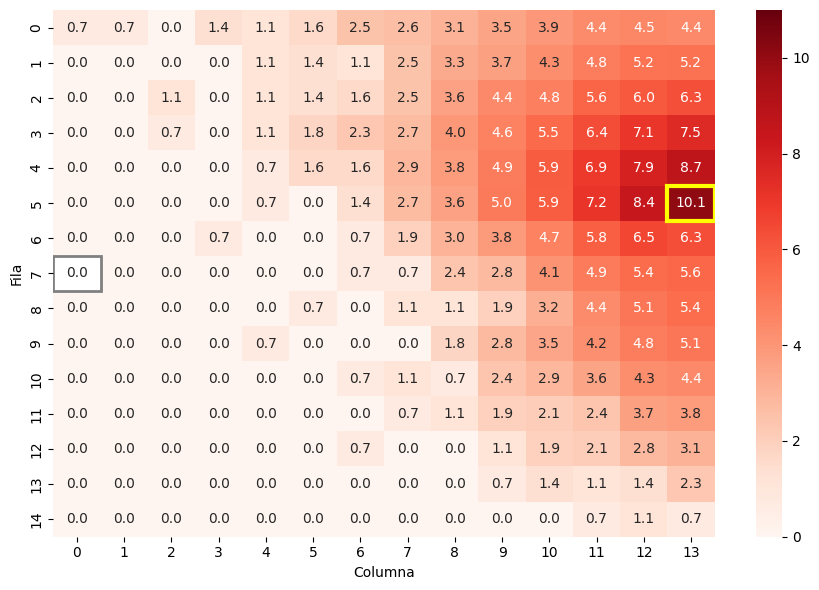

In [73]:
heatmap_accion(df_v3, 4)

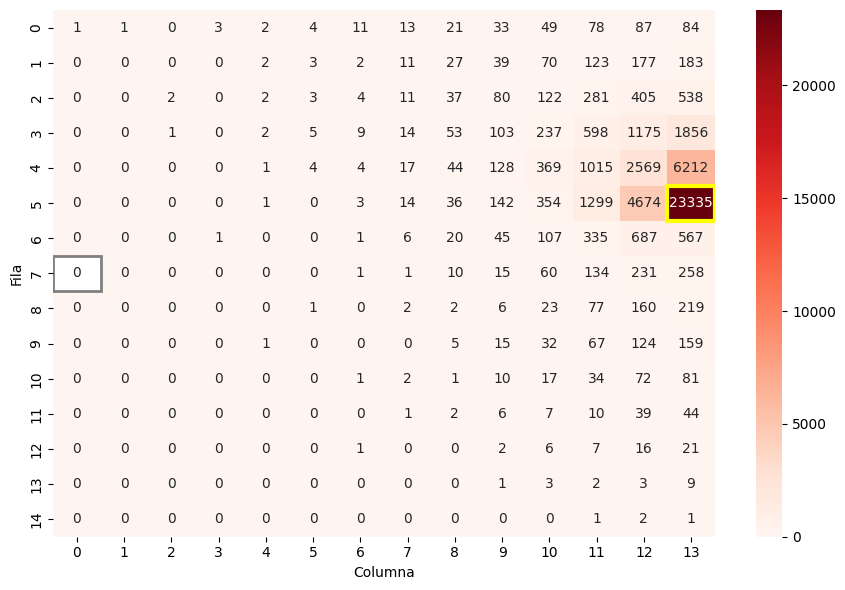

In [74]:
heatmap_accion(df_v3, 4, log=False)

Mapa calor intercepciones del balón

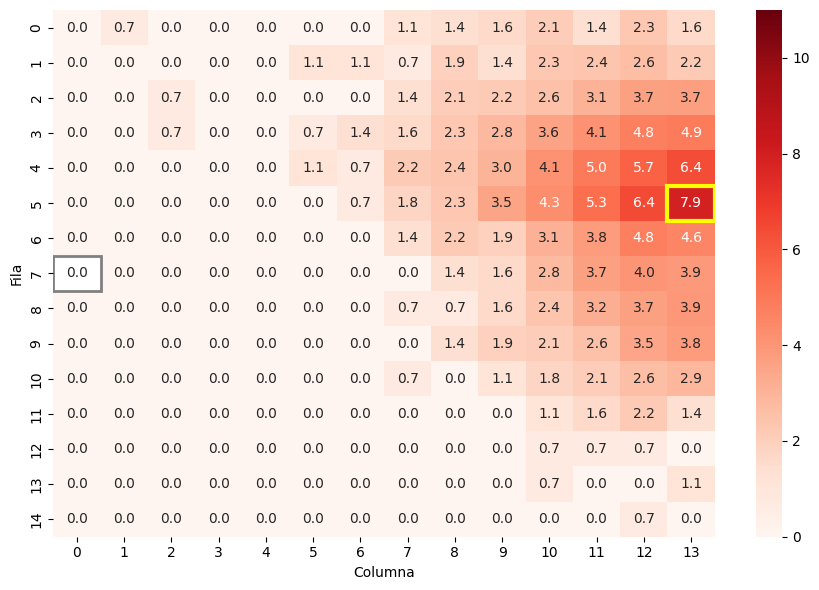

In [82]:
heatmap_intercepciones(df_v3, log=True)

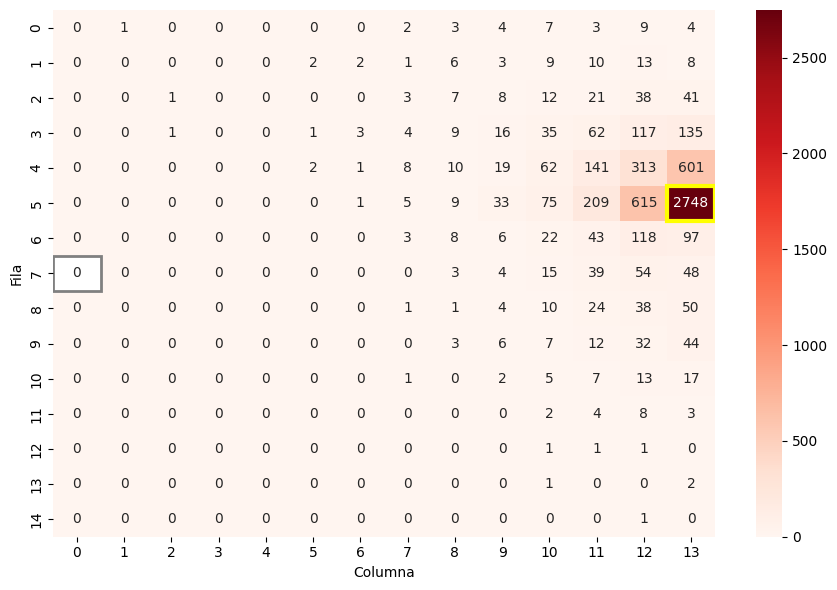

In [81]:
heatmap_intercepciones(df_v3, log=False)

Mapa de calor de posiciones de jugador con posesión del balón

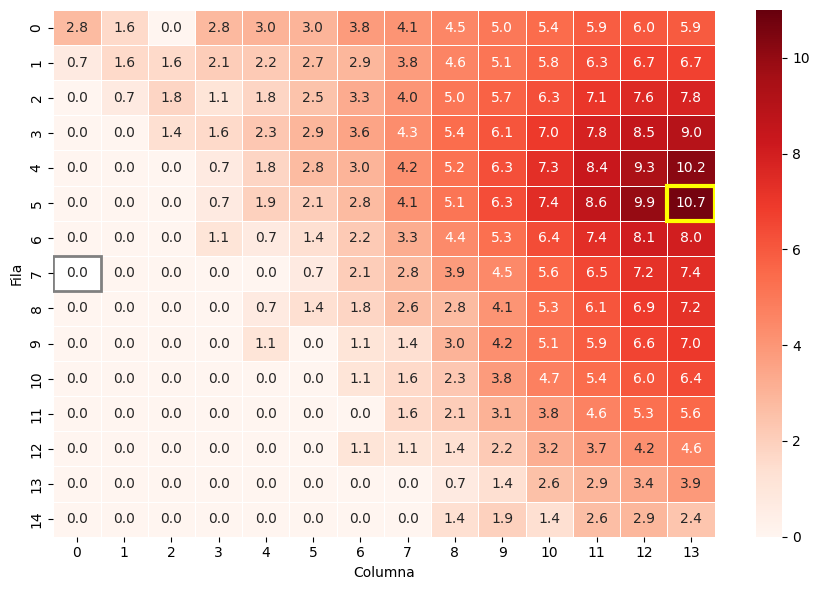

In [75]:
heatmap_pos_balon(df_v3, log=True)

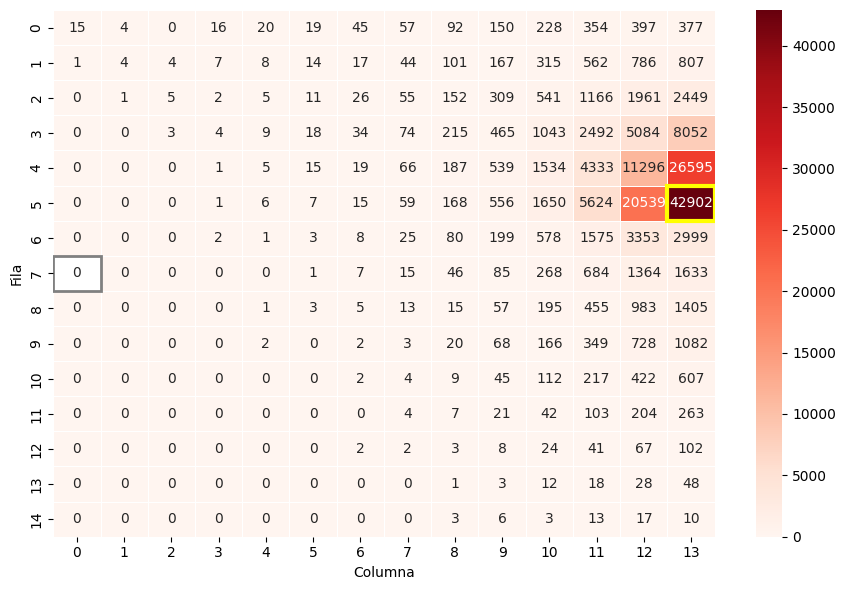

In [76]:
heatmap_pos_balon(df_v3, log=False)

In [26]:
# Calcular la duración media de los episodios (por run_id y episodio)
episodio_lens = df_v3.groupby(["run_id", "episode"])["step"].count()
print(f"Duración mediana de los episodios: {episodio_lens.median():.2f} pasos") 
print(f"Duración media de los episodios: {episodio_lens.mean():.2f} pasos")

Duración mediana de los episodios: 2.00 pasos
Duración media de los episodios: 3.22 pasos


In [27]:
df_v3["total_iters"] = pd.to_numeric(df_v3["total_iters"], errors="coerce")

resumen_v3 = []
for iters, group in df_v3.groupby("total_iters"):
    # Recompensa media por episodio
    reward_by_ep = group[group["done"] == True].groupby(["run_id", "episode"])["reward"].sum()
    recompensa_media = reward_by_ep.mean()
    recompensa_max = reward_by_ep.max()
    # % tiros inmediatos (primer paso del episodio contiene un 4 en la lista de acciones)
    episodios = group.groupby(["run_id", "episode"])
    tiros_inmediatos = 0
    total_episodios = 0
    for _, ep in episodios:
        acciones = ep["action"].tolist()
        if len(acciones) > 0:
            acc_0 = acciones[0]
            # Si es string, evalúa a lista
            if isinstance(acc_0, str):
                try:
                    acc_0 = eval(acc_0)
                except Exception:
                    continue
            # Si es lista y contiene un 4, es tiro inmediato
            if isinstance(acc_0, list) and 4 in acc_0:
                tiros_inmediatos += 1
            total_episodios += 1
    pct_tiros_inmediatos = 100 * tiros_inmediatos / total_episodios if total_episodios > 0 else 0
    resumen_v3.append({
        "Iteraciones": int(iters),
        "Recompensa media": f"{recompensa_media:.2f}",
        "% tiros inmediatos": f"{pct_tiros_inmediatos:.1f}%",
        "Recompensa máx.": f"{recompensa_max:.2f}"
    })

tabla_resumen_v3 = pd.DataFrame(resumen_v3).sort_values("Iteraciones")
display(tabla_resumen_v3)


,Iteraciones,Recompensa media,% tiros inmediatos,Recompensa máx.
0,500,-0.07,15.9%,1.06
1,1000,-0.11,16.9%,1.05
2,10000,-0.05,25.9%,1.05
3,50000,-0.01,31.9%,1.31
4,100000,0.02,35.5%,1.34


---

## Version 4: Asignación de roles y datos NBA

---

Mapa calor de posiciones de lanzamiento

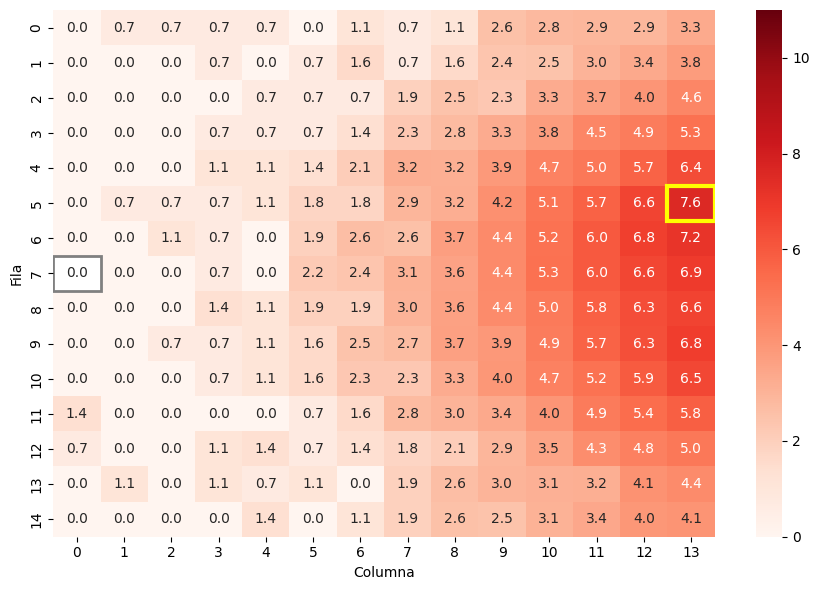

In [77]:
heatmap_accion(df_v4, 4)

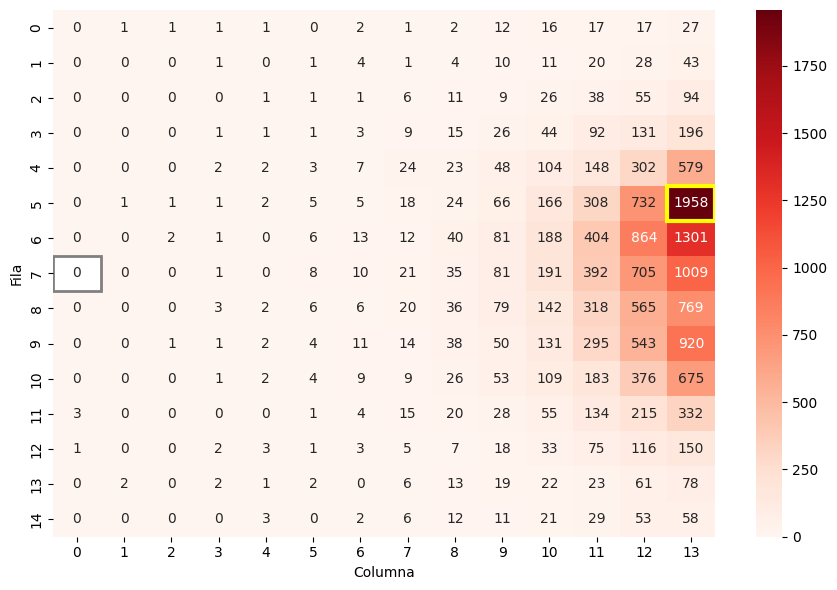

In [78]:
heatmap_accion(df_v4, 4, log=False)

Mapa calor de posiciones de intercepción del balón

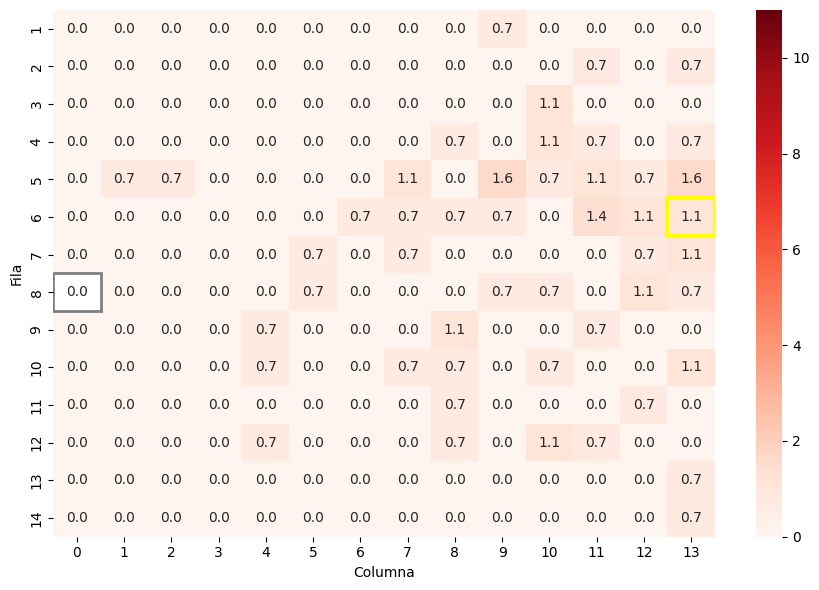

In [83]:
heatmap_intercepciones(df_v4, log=True)

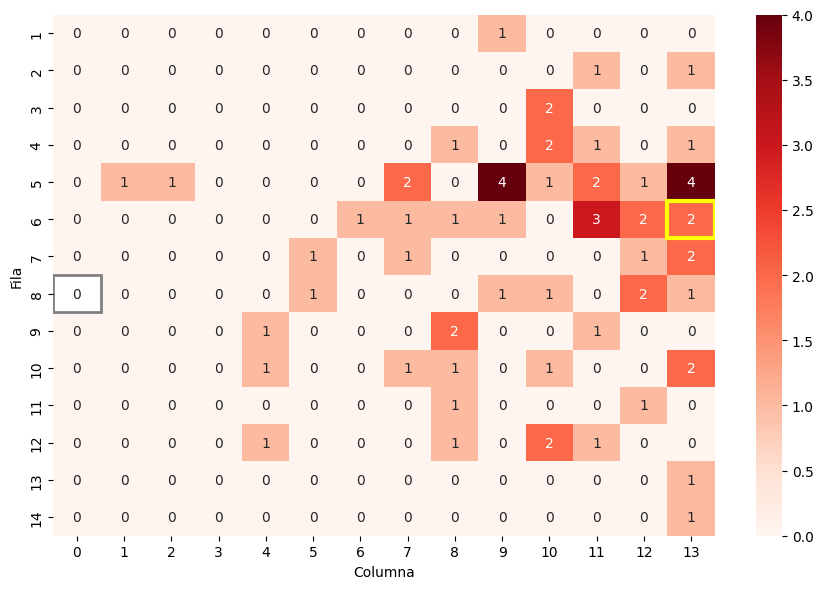

In [84]:
heatmap_intercepciones(df_v4, log=False)

Mapa calor de posiciones del jugador con posesión del balón

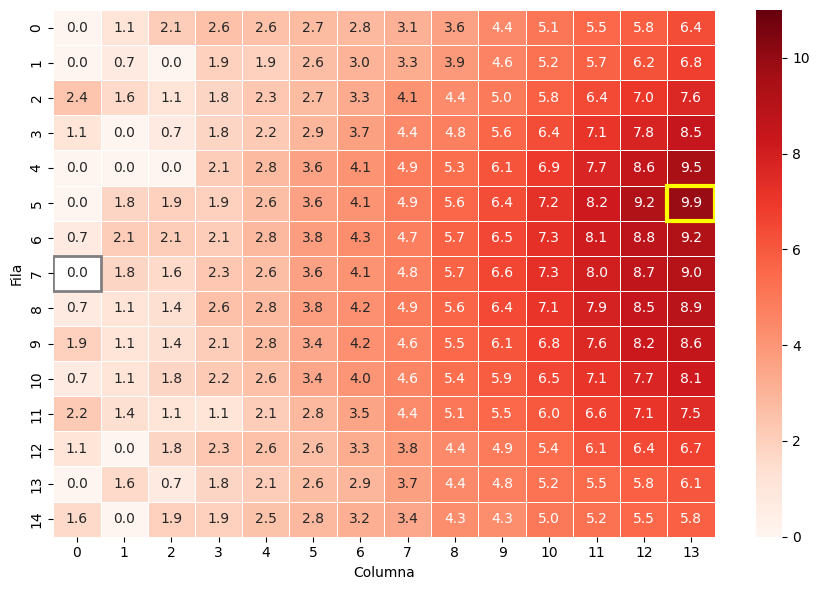

In [79]:
heatmap_pos_balon(df_v4, log=True)

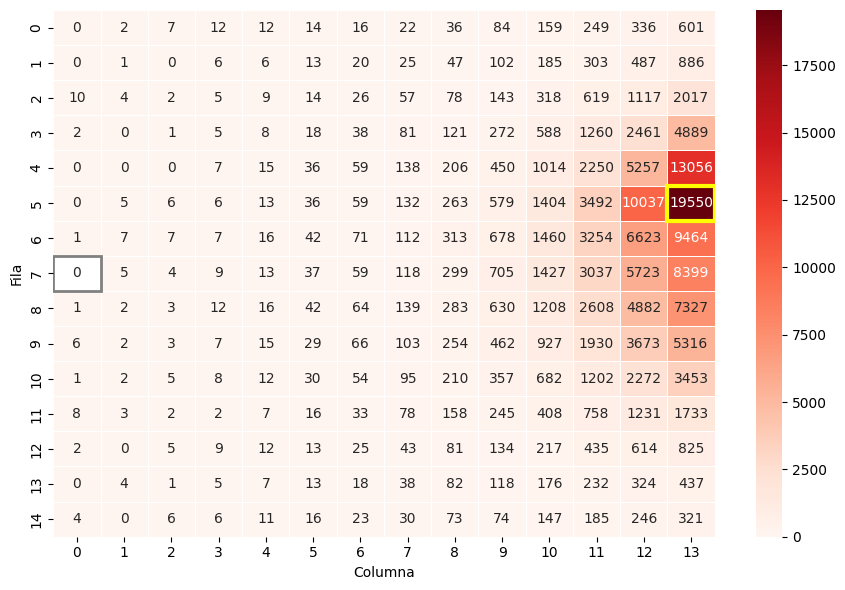

In [80]:
heatmap_pos_balon(df_v4, log=False)

Duración episodios:

In [32]:
# Calcular la duración media de los episodios (por run_id y episodio)
episodio_lens = df_v4.groupby(["run_id", "episode"])["step"].count()
print(f"Duración mediana de los episodios: {episodio_lens.median():.2f} pasos") 
print(f"Duración media de los episodios: {episodio_lens.mean():.2f} pasos")

Duración mediana de los episodios: 7.00 pasos
Duración media de los episodios: 9.23 pasos


Resultados en función del rol de cada jugador:

- Después del entrenamiento

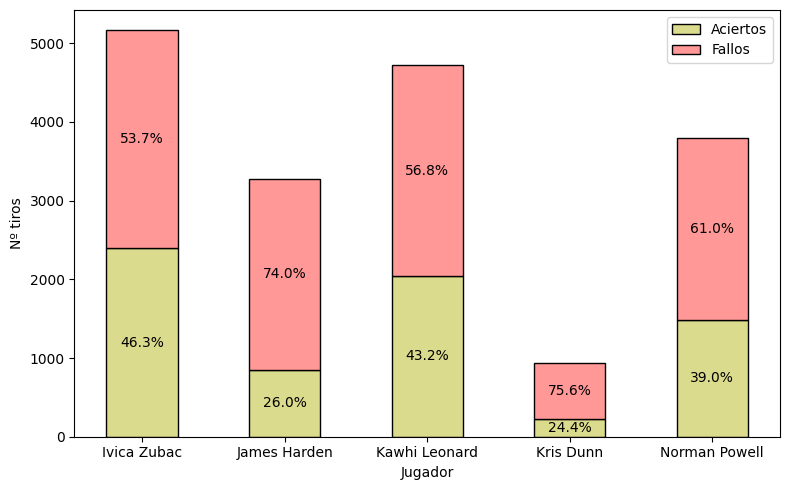

In [95]:
# Gráfico de barras acumuladas: número de tiros por jugador, con porcentaje de acierto y fallo como texto en la barra

player_name_map = {
    "ivica_zubac": "Ivica Zubac",
    "james_harden": "James Harden",
    "kawhi_leonard": "Kawhi Leonard",
    "kris_dunn": "Kris Dunn",
    "norman_powell": "Norman Powell",
}

players = list(player_name_map.values())

# Suma total de aciertos y fallos por jugador (todas las iteraciones)
aciertos_tot = []
fallos_tot = []
porc_aciertos = []
porc_fallos = []

for player in players:
    aciertos = len(df_shots[(df_shots["player_name"] == player) & (df_shots["shot"] == "shot_successful")])
    fallos = len(df_shots[(df_shots["player_name"] == player) & (df_shots["shot"] == "shot_failed")])
    total = aciertos + fallos
    aciertos_tot.append(aciertos)
    fallos_tot.append(fallos)
    if total > 0:
        porc_aciertos.append(100 * aciertos / total)
        porc_fallos.append(100 * fallos / total)
    else:
        porc_aciertos.append(0)
        porc_fallos.append(0)

x = np.arange(len(players))
width = 0.5
tab20 = sns.color_palette("tab20", 20)
colors = [tab20[17], tab20[7]]  # verde pastel, rojo pastel

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x, aciertos_tot, width, label='Aciertos', color=colors[0], edgecolor="black")
bars2 = ax.bar(x, fallos_tot, width, bottom=aciertos_tot, label='Fallos', color=colors[1], edgecolor="black")

ax.set_xticks(x)
ax.set_xticklabels(players, rotation=0)
ax.set_ylabel('Nº tiros')
ax.set_xlabel('Jugador')
ax.legend()
plt.tight_layout()

# Añade el porcentaje encima de cada segmento
for i in range(len(players)):
    if aciertos_tot[i] > 0:
        ax.text(i, aciertos_tot[i] / 2, f"{porc_aciertos[i]:.1f}%", ha="center", va="center", fontsize=10, color="black")
    if fallos_tot[i] > 0:
        ax.text(i, aciertos_tot[i] + fallos_tot[i] / 2, f"{porc_fallos[i]:.1f}%", ha="center", va="center", fontsize=10, color="black")

plt.show()

- De los datos extraidos directamente de la NBA:

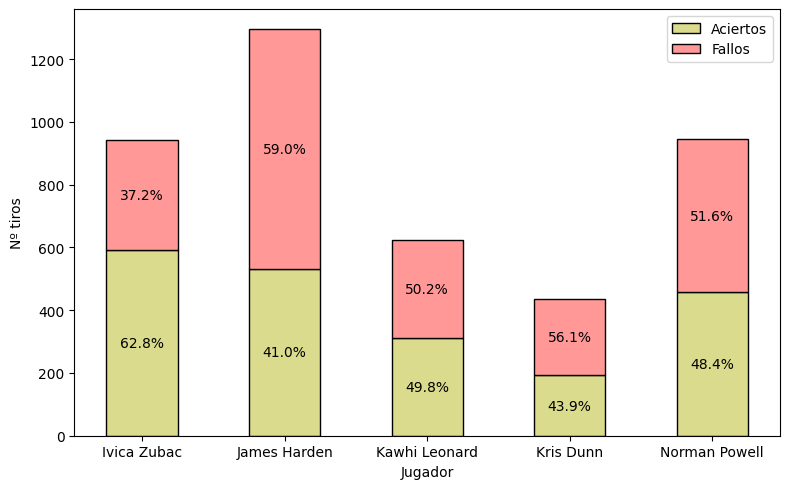

In [ ]:
# Ruta a los archivos CSV de los jugadores
csv_files = glob.glob("v4_player_roles_influence/nba_api/data/*_shots.csv")

# Diccionario para guardar resultados por jugador
results = {}

for file in csv_files:
    df = pd.read_csv(file)
    player = df["PLAYER_NAME"].iloc[0]
    # Cuenta aciertos y fallos usando EVENT_TYPE
    aciertos = (df["EVENT_TYPE"] == "Made Shot").sum()
    fallos = (df["EVENT_TYPE"] == "Missed Shot").sum()
    total = aciertos + fallos
    pct_aciertos = 100 * aciertos / total if total > 0 else 0
    pct_fallos = 100 * fallos / total if total > 0 else 0
    results[player] = {
        "Aciertos": aciertos,
        "Fallos": fallos,
        "Porc_Aciertos": pct_aciertos,
        "Porc_Fallos": pct_fallos
    }

# Preparar datos para el gráfico
players = list(results.keys())
aciertos_tot = [results[p]["Aciertos"] for p in players]
fallos_tot = [results[p]["Fallos"] for p in players]
porc_aciertos = [results[p]["Porc_Aciertos"] for p in players]
porc_fallos = [results[p]["Porc_Fallos"] for p in players]

x = np.arange(len(players))
width = 0.5
tab20 = sns.color_palette("tab20", 20)
colors = [tab20[17], tab20[7]]  # verde pastel, rojo pastel

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x, aciertos_tot, width, label='Aciertos', color=colors[0], edgecolor="black")
bars2 = ax.bar(x, fallos_tot, width, bottom=aciertos_tot, label='Fallos', color=colors[1], edgecolor="black")

ax.set_xticks(x)
ax.set_xticklabels(players, rotation=0)
ax.set_ylabel('Nº tiros')
ax.set_xlabel('Jugador')
ax.legend()
plt.tight_layout()

# Añade el porcentaje encima de cada segmento
for i in range(len(players)):
    if aciertos_tot[i] > 0:
        ax.text(i, aciertos_tot[i] / 2, f"{porc_aciertos[i]:.1f}%", ha="center", va="center", fontsize=10, color="black")
    if fallos_tot[i] > 0:
        ax.text(i, aciertos_tot[i] + fallos_tot[i] / 2, f"{porc_fallos[i]:.1f}%", ha="center", va="center", fontsize=10, color="black")

plt.show()

Evolución de tiros intentados en cada entrenamiento:

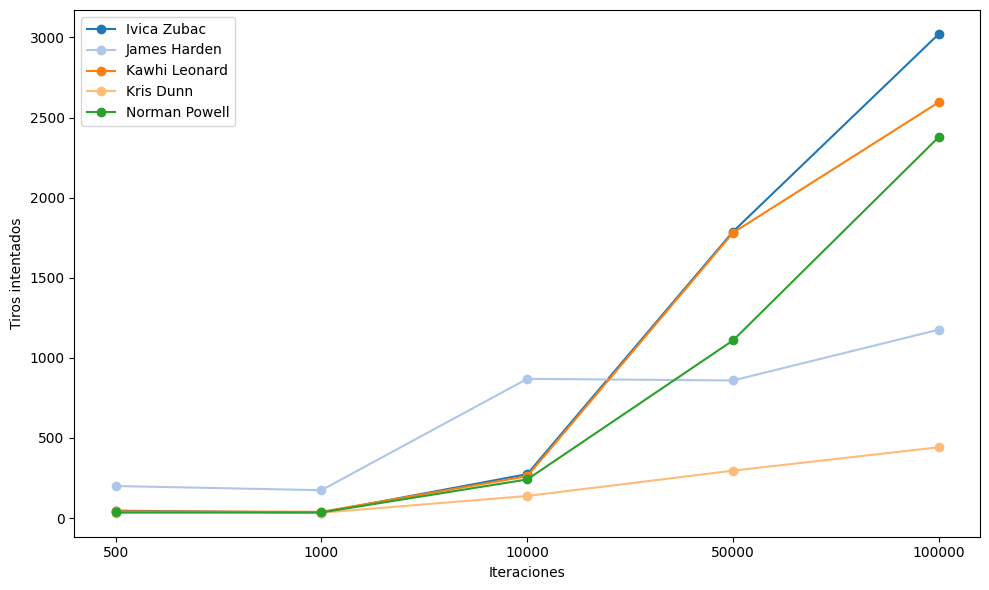

In [96]:
players = list(player_name_map.values())

# top_iters debe estar definido con los valores de iteraciones que quieres mostrar, por ejemplo:
top_iters = sorted(df_shots["total_iters"].dropna().unique())
# Si ya está definido en tu notebook, no necesitas esta línea.

# Para cada jugador, obtener la evolución de tiros intentados por cada iteración (top_iters)
tiros_evol = {player: [] for player in players}

for it in top_iters:
    df_it = df_shots[df_shots["total_iters"] == it]
    for player in players:
        tiros_evol[player].append(len(df_it[df_it["player_name"] == player]))

fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette("tab20", len(players))

# Usar posiciones igualmente espaciadas para las x
x = np.arange(len(top_iters))

for idx, player in enumerate(players):
    ax.plot(x, tiros_evol[player], marker='o', label=player, color=colors[idx])

ax.set_xticks(x)
ax.set_xticklabels([str(int(it)) for it in top_iters])
ax.set_xlabel("Iteraciones")
ax.set_ylabel("Tiros intentados")
ax.legend(fontsize=10)
plt.tight_layout()
plt.show()

Resumen recompensas 

In [34]:
df_v4["total_iters"] = pd.to_numeric(df_v4["total_iters"], errors="coerce")

resumen_v4 = []
for iters, group in df_v4.groupby("total_iters"):
    # Recompensa media por episodio
    reward_by_ep = group[group["done"] == True].groupby(["run_id", "episode"])["reward"].sum()
    recompensa_media = reward_by_ep.mean()
    recompensa_max = reward_by_ep.max()
    # % tiros inmediatos (primer paso del episodio contiene un 4 en la lista de acciones)
    episodios = group.groupby(["run_id", "episode"])
    tiros_inmediatos = 0
    total_episodios = 0
    for _, ep in episodios:
        acciones = ep["action"].tolist()
        if len(acciones) > 0:
            acc_0 = acciones[0]
            # Si es string, evalúa a lista
            if isinstance(acc_0, str):
                try:
                    acc_0 = eval(acc_0)
                except Exception:
                    continue
            # Si es lista y contiene un 4, es tiro inmediato
            if isinstance(acc_0, list) and 4 in acc_0:
                tiros_inmediatos += 1
            total_episodios += 1
    pct_tiros_inmediatos = 100 * tiros_inmediatos / total_episodios if total_episodios > 0 else 0
    resumen_v4.append({
        "Iteraciones": int(iters),
        "Recompensa media": f"{recompensa_media:.2f}",
        "% tiros inmediatos": f"{pct_tiros_inmediatos:.1f}%",
        "Recompensa máx.": f"{recompensa_max:.2f}"
    })

tabla_resumen_v4 = pd.DataFrame(resumen_v4).sort_values("Iteraciones")
display(tabla_resumen_v4)

,Iteraciones,Recompensa media,% tiros inmediatos,Recompensa máx.
0,500,0.39,18.2%,1.56
1,1000,0.31,13.0%,1.56
2,10000,0.36,14.9%,1.80
3,50000,0.49,3.9%,3.00
4,100000,0.51,2.8%,3.00


---

## Búsqueda de episodios 

---

In [10]:
# Filtra solo ese run_id en df_v4
run_id_target = "b3d62b11a0384c8dabf11cd58dd6b666"
df_v4_run = df_v4[df_v4["run_id"] == run_id_target]

# Busca para cada episodio si el último paso termina en columna < 6
episodios_final_col = []

for ep, ep_df in df_v4_run.groupby("episode"):
    last_step = ep_df[ep_df["step"] == ep_df["step"].max()]
    if not last_step.empty and last_step.iloc[0]["player_col"] < 6:
        episodios_final_col.append({
            "episode": ep,
            "final_col": last_step.iloc[0]["player_col"],
            "ep_df": ep_df  # Guarda el DataFrame del episodio para análisis posterior
        })

if episodios_final_col:
    print("Episodios que terminan con el jugador en columna < 6:")
    for item in episodios_final_col:
        print(f"Episodio: {item['episode']}, Columna final: {item['final_col']}")
else:
    print("Ningún episodio termina con el jugador en columna < 6.")

# Calcular el número de pases (acción 5) en cada episodio seleccionado
episodios_con_pases = []
for item in episodios_final_col:
    ep = item["episode"]
    ep_df = item["ep_df"]
    count_pases = 0
    for action in ep_df["action"]:
        if isinstance(action, str):
            try:
                action_eval = eval(action)
            except Exception:
                continue
        else:
            action_eval = action
        if isinstance(action_eval, list):
            count_pases += action_eval.count(5)
        elif action_eval == 5:
            count_pases += 1
    episodios_con_pases.append({
        "episode": ep,
        "final_col": item["final_col"],
        "num_pases": count_pases
    })

# Ordenar de mayor a menor por número de pases
episodios_con_pases = sorted(episodios_con_pases, key=lambda x: x["num_pases"], reverse=True)

print("\nEpisodios seleccionados ordenados por número de pases (acción 5):")
for item in episodios_con_pases:
    print(f"Episodio: {item['episode']}, Columna final: {item['final_col']}, Nº pases: {item['num_pases']}")

if episodios_con_pases:
    ep_max_pases = episodios_con_pases[0]["episode"]
    max_pases = episodios_con_pases[0]["num_pases"]
    print(f"\nEpisodio (de los seleccionados) con más acciones de pase (acción 5): {ep_max_pases} con {max_pases} pases.")
else:
    print("No se encontraron episodios con acciones de pase (acción 5) entre los seleccionados.")

Episodios que terminan con el jugador en columna < 6:
Episodio: 1864, Columna final: 3
Episodio: 2585, Columna final: 5
Episodio: 2934, Columna final: 5
Episodio: 3303, Columna final: 4
Episodio: 3521, Columna final: 5
Episodio: 3844, Columna final: 5
Episodio: 3859, Columna final: 5
Episodio: 3893, Columna final: 3
Episodio: 3953, Columna final: 5
Episodio: 3985, Columna final: 5
Episodio: 4004, Columna final: 2
Episodio: 4048, Columna final: 3
Episodio: 4209, Columna final: 5
Episodio: 4293, Columna final: 3
Episodio: 4309, Columna final: 5
Episodio: 4369, Columna final: 2
Episodio: 4382, Columna final: 5
Episodio: 4494, Columna final: 5
Episodio: 4495, Columna final: 3
Episodio: 4531, Columna final: 5
Episodio: 4579, Columna final: 3
Episodio: 4664, Columna final: 4
Episodio: 4796, Columna final: 4
Episodio: 4828, Columna final: 3
Episodio: 4834, Columna final: 4
Episodio: 4916, Columna final: 2
Episodio: 4964, Columna final: 1
Episodio: 5018, Columna final: 1
Episodio: 5123, Column